# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For dataset
from datasets import load_dataset

# For NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sovan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sovan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# 2. Load Dataset

In [ ]:
# Load the dataset from the "facebook/empathetic_dialogues" repository on Hugging Face.
# This dataset contains dialogues with fields such as conversation context, responses,
# emotion labels, and additional metadata.


dataset = load_dataset("facebook/empathetic_dialogues", trust_remote_code=True) # enable trust to download


Generating test split: 100%|██████████| 10943/10943 [00:01<00:00, 10820.54 examples/s]


In [15]:
df_train = pd.DataFrame(dataset["train"])

In [16]:
df_train

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,
...,...,...,...,...,...,...,...,...
76668,hit:12424_conv:24848,5,sentimental,I found some pictures of my grandma in the att...,389,Yeah reminds me of the good old days. I miss ...,5|5|5_5|5|5,
76669,hit:12424_conv:24849,1,surprised,I woke up this morning to my wife telling me s...,294,I woke up this morning to my wife telling me s...,5|5|5_5|5|5,
76670,hit:12424_conv:24849,2,surprised,I woke up this morning to my wife telling me s...,389,Oh hey that's awesome! That is awesome right?,5|5|5_5|5|5,
76671,hit:12424_conv:24849,3,surprised,I woke up this morning to my wife telling me s...,294,It is soooo awesome. We have been wanting a b...,5|5|5_5|5|5,


## [2.1] Basic Cleaning

In [19]:
print(df.isnull().sum())

Unnamed: 0                  0
Situation                   0
emotion                     4
empathetic_dialogues        0
labels                      0
Unnamed: 5              64523
Unnamed: 6              64631
dtype: int64


In [49]:
# Select relevant columns

df = df_train[['conv_id','utterance', 'context', 'prompt', 'speaker_idx']].copy()

In [50]:
df

,conv_id,utterance,context,prompt,speaker_idx
0,hit:0_conv:1,I remember going to see the fireworks with my ...,sentimental,I remember going to the fireworks with my best...,1
1,hit:0_conv:1,Was this a friend you were in love with_comma_...,sentimental,I remember going to the fireworks with my best...,0
2,hit:0_conv:1,This was a best friend. I miss her.,sentimental,I remember going to the fireworks with my best...,1
3,hit:0_conv:1,Where has she gone?,sentimental,I remember going to the fireworks with my best...,0
4,hit:0_conv:1,We no longer talk.,sentimental,I remember going to the fireworks with my best...,1
...,...,...,...,...,...
76668,hit:12424_conv:24848,Yeah reminds me of the good old days. I miss ...,sentimental,I found some pictures of my grandma in the att...,389
76669,hit:12424_conv:24849,I woke up this morning to my wife telling me s...,surprised,I woke up this morning to my wife telling me s...,294
76670,hit:12424_conv:24849,Oh hey that's awesome! That is awesome right?,surprised,I woke up this morning to my wife telling me s...,389
76671,hit:12424_conv:24849,It is soooo awesome. We have been wanting a b...,surprised,I woke up this morning to my wife telling me s...,294


In [51]:
# Rename columns

df.rename(columns={
    "utterance": "text",
    "context": "emotion_context",
    "prompt": "situation",
    "speaker_idx": "speaker"
}, inplace=True)

In [52]:
df['text'][1]

'Was this a friend you were in love with_comma_ or just a best friend?'

In [53]:
df['situation'][1]

'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.'

In [54]:
df.isna().sum()

conv_id            0
text               0
emotion_context    0
situation          0
speaker            0
dtype: int64

Here, we replace '_comma_' with ',' and remove weird symbols 

In [55]:
def clean_text(text):
    text = re.sub(r"_comma_", ",", text)
    text = re.sub(r"[^a-zA-Z0-9\s,.!?']", "", text)  # remove weird symbols
    text = text.strip()
    return text

df["text"] = df["text"].apply(clean_text)
df["situation"] = df["situation"].apply(clean_text)

In [56]:
df['text'][1]

'Was this a friend you were in love with, or just a best friend?'

Remove stops words and tokenize

In [57]:
stop_words = set(stopwords.words('english'))

def preprocess_tokens(text):
    tokens = word_tokenize(text.lower())
    filtered = [w for w in tokens if w.isalnum() and w not in stop_words]
    return filtered

df["tokens"] = df["text"].apply(preprocess_tokens)

In [58]:
df

,conv_id,text,emotion_context,situation,speaker,tokens
0,hit:0_conv:1,I remember going to see the fireworks with my ...,sentimental,I remember going to the fireworks with my best...,1,"[remember, going, see, fireworks, best, friend..."
1,hit:0_conv:1,"Was this a friend you were in love with, or ju...",sentimental,I remember going to the fireworks with my best...,0,"[friend, love, best, friend]"
2,hit:0_conv:1,This was a best friend. I miss her.,sentimental,I remember going to the fireworks with my best...,1,"[best, friend, miss]"
3,hit:0_conv:1,Where has she gone?,sentimental,I remember going to the fireworks with my best...,0,[gone]
4,hit:0_conv:1,We no longer talk.,sentimental,I remember going to the fireworks with my best...,1,"[longer, talk]"
...,...,...,...,...,...,...
76668,hit:12424_conv:24848,Yeah reminds me of the good old days. I miss ...,sentimental,I found some pictures of my grandma in the att...,389,"[yeah, reminds, good, old, days, miss, grandma..."
76669,hit:12424_conv:24849,I woke up this morning to my wife telling me s...,surprised,I woke up this morning to my wife telling me s...,294,"[woke, morning, wife, telling, pregnant]"
76670,hit:12424_conv:24849,Oh hey that's awesome! That is awesome right?,surprised,I woke up this morning to my wife telling me s...,389,"[oh, hey, awesome, awesome, right]"
76671,hit:12424_conv:24849,It is soooo awesome. We have been wanting a b...,surprised,I woke up this morning to my wife telling me s...,294,"[soooo, awesome, wanting, baby, long, ca, wait..."


Here, we map speaker and agent response

In [59]:
# Check speaker values
print(df["speaker"].value_counts())

speaker
27     2808
1      2581
126    1937
4      1885
238    1748
       ... 
492       2
71        2
783       2
730       2
757       2
Name: count, Length: 789, dtype: int64


In [60]:
df["role"] = df["speaker"].apply(lambda x: "Customer" if x % 2 == 1 else "Agent")

In [61]:
df

,conv_id,text,emotion_context,situation,speaker,tokens,role
0,hit:0_conv:1,I remember going to see the fireworks with my ...,sentimental,I remember going to the fireworks with my best...,1,"[remember, going, see, fireworks, best, friend...",Customer
1,hit:0_conv:1,"Was this a friend you were in love with, or ju...",sentimental,I remember going to the fireworks with my best...,0,"[friend, love, best, friend]",Agent
2,hit:0_conv:1,This was a best friend. I miss her.,sentimental,I remember going to the fireworks with my best...,1,"[best, friend, miss]",Customer
3,hit:0_conv:1,Where has she gone?,sentimental,I remember going to the fireworks with my best...,0,[gone],Agent
4,hit:0_conv:1,We no longer talk.,sentimental,I remember going to the fireworks with my best...,1,"[longer, talk]",Customer
...,...,...,...,...,...,...,...
76668,hit:12424_conv:24848,Yeah reminds me of the good old days. I miss ...,sentimental,I found some pictures of my grandma in the att...,389,"[yeah, reminds, good, old, days, miss, grandma...",Customer
76669,hit:12424_conv:24849,I woke up this morning to my wife telling me s...,surprised,I woke up this morning to my wife telling me s...,294,"[woke, morning, wife, telling, pregnant]",Agent
76670,hit:12424_conv:24849,Oh hey that's awesome! That is awesome right?,surprised,I woke up this morning to my wife telling me s...,389,"[oh, hey, awesome, awesome, right]",Customer
76671,hit:12424_conv:24849,It is soooo awesome. We have been wanting a b...,surprised,I woke up this morning to my wife telling me s...,294,"[soooo, awesome, wanting, baby, long, ca, wait...",Agent


In [62]:
# Group utterances by conversation ID to reconstruct dialogues
grouped_dialogues = df.groupby("conv_id")["text"].apply(list).reset_index()

In [68]:
grouped_dialogues['text'][2]

['I really like the new paint job on my house.',
 "That's nice. What color did you paint it?",
 'I went with blue and yellow.',
 'Those are swell colors! I am sure they will bring any guests much joy and merriment.']

Distrubution of emotions

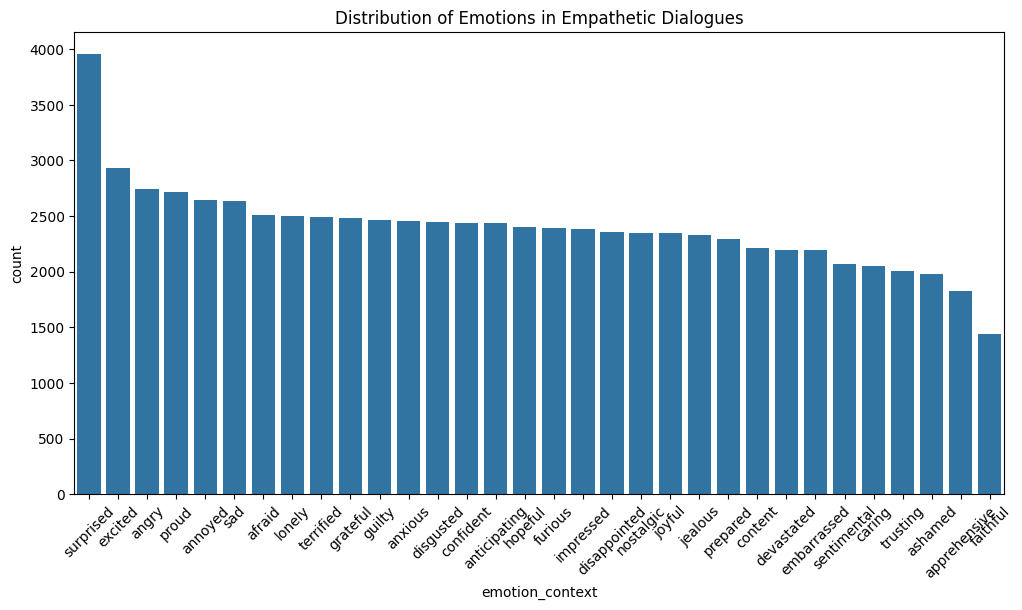

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="emotion_context", order=df["emotion_context"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Emotions in Empathetic Dialogues")
plt.show()

In [70]:
df.to_csv('../data/empathetic_chat_cleaned.csv')